In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

conn = sqlite3.connect("movie.sqlite")
cur = conn.cursor()

In [2]:
query1 = "SELECT name FROM sqlite_master WHERE type='table'"
pd.read_sql(query1, conn)

name
0     IMDB
1  earning
2    genre

In [3]:
query2 = "SELECT * FROM IMDB LIMIT 5;"
pd.read_sql(query2, conn)

Movie_id                    Title  Rating  TotalVotes MetaCritic  \
0    36809  12 Years a Slave (2013)     8.1      496092         96   
1    30114         127 Hours (2010)     7.6      297075         82   
2    37367             50/50 (2011)     7.7      283935         72   
3    49473        About Time (2013)     7.8      225412              
4    14867             Amour (2012)     7.9       76121         94   

       Budget  Runtime CVotes10 CVotes09 CVotes08  ... Votes3044 Votes3044M  \
0  20000000.0  134 min    75556   126223   161460  ...       8.0        7.9   
1  18000000.0   94 min    28939    44110    98845  ...       7.5        7.5   
2   8000000.0  100 min    28304    47501    99524  ...       7.6        7.6   
3  12000000.0  123 min    38556    43170    70850  ...       7.6        7.6   
4   8900000.0  127 min    11093    15944    22942  ...       7.7        7.7   

  Votes3044F Votes45A Votes45AM Votes45AF VotesIMDB Votes1000 VotesUS VotesnUS  
0        8.0      7.8       7.8       8.1       8.0       7.7     8.3      8.0  
1        7.5      7.3       7.3       7.5       7.6       7.0     7.7      7.6  
2        7.6      7.4       7.4       7.5       7.4       7.0     7.9      7.6  
3        7.7      7.6       7.5       7.8       7.7       6.9     7.8      7.7  
4        7.9      7.9       7.8       8.1       6.6       7.2     7.9      7.8  

[5 rows x 52 columns]

In [4]:
query3 = "SELECT * FROM earning LIMIT 5;"
pd.read_sql(query3, conn)

Movie_id  Domestic    Worldwide
0    36809  56671993  187733202.0
1    30114  18335230   60738797.0
2    37367  35014192   39187783.0
3    49473  15322921   87100449.0
4    14867   6739492   19839492.0

In [5]:
query4 = "SELECT * FROM genre;"
pd.read_sql(query4, conn)

Movie_id      genre
0      36809  Biography
1      30114  Adventure
2      37367     Comedy
3      49473     Comedy
4      14867      Drama
..       ...        ...
346    38262           
347    10023     Comedy
348    27783     Sci-Fi
349    42294     Sci-Fi
350    32217     Comedy

[351 rows x 2 columns]

In [6]:
query5= " SELECT IMDB.Movie_id, IMDB.Title, IMDB.Rating, IMDB.Runtime, IMDB.Budget, IMDB.TotalVotes,genre.genre,earning.Domestic, earning.Worldwide, (earning.Domestic + earning.Worldwide) AS Total_Earnings,(earning.Domestic + earning.Worldwide - IMDB.Budget) AS Profit FROM IMDB LEFT JOIN genre ON IMDB.Movie_id = genre.Movie_id LEFT JOIN earning ON IMDB.Movie_id = earning.Movie_id ORDER BY IMDB.Movie_id;"
tables=pd.read_sql(query5, conn)

# N 1

# This pair plot shows the relationships between Rating, TotalVotes, Domestic Earnings, and Worldwide Earnings. 

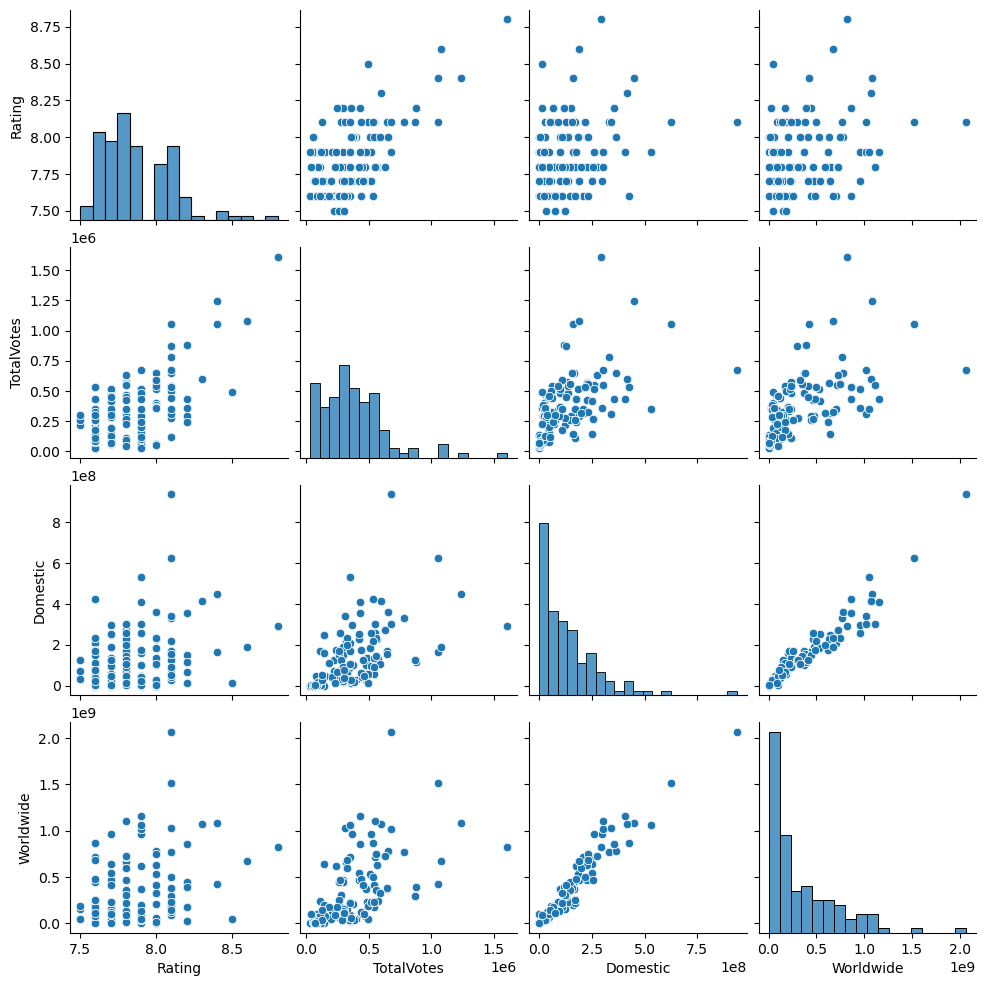

In [9]:
sns.pairplot(tables[['Rating', 'TotalVotes', 'Domestic', 'Worldwide']])
plt.show()

## There is a strong positive correlation between Domestic and Worldwide earnings, while TotalVotes are moderately correlated with higher Ratings, but Ratings themselves show no significant relationship with earnings.

# N 2

# This pair plot shows the relationships between Domestic Earnings, Worldwide Earnings, and Ratings for movies across different genres. 

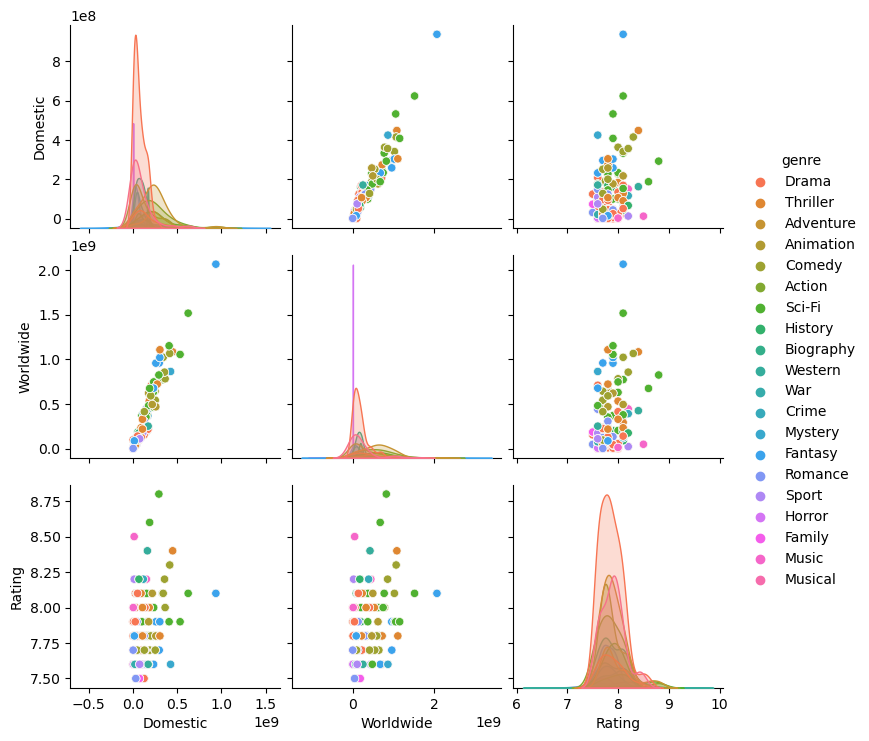

In [13]:
sns.pairplot(tables, hue="genre", vars=[ "Domestic", "Worldwide", "Rating"])
plt.show()

## There is a strong positive correlation between Domestic and Worldwide earnings, while Ratings are more concentrated between 7 and 9 with no clear relationship to earnings.

# N 3

# Heatmap of Average Ratings by Genre

In [17]:
query6 = "SELECT genre.genre, AVG(IMDB.Rating) AS Avg_Rating FROM genre INNER JOIN IMDB ON genre.Movie_id = IMDB.Movie_id GROUP BY genre.genre ORDER BY Avg_Rating DESC LIMIT 10;"
highest_rating_genre=pd.read_sql(query6, conn)
highest_rating_genre

genre  Avg_Rating
0      Music    8.233333
1    Western    8.000000
2     Sci-Fi    7.994444
3    History    7.950000
4    Mystery    7.914286
5  Animation    7.900000
6  Adventure    7.895349
7               7.890244
8     Action    7.875758
9      Crime    7.872727

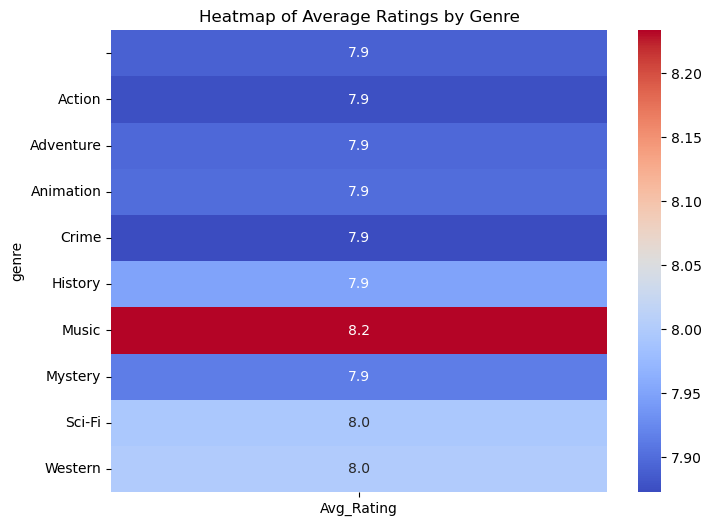

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(highest_rating_genre.pivot_table(index="genre", values="Avg_Rating"), annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Heatmap of Average Ratings by Genre")
plt.show()

## From the heatmap, the Music genre stands out with the highest average rating of 8.2, shown in red. Other genres, such as Sci-Fi and Western, also have slightly higher ratings (8.0), but most genres, including Action, Adventure, and Crime, cluster around an average rating of 7.9. This suggests that the Music genre consistently receives higher ratings compared to others.

# N 4

# Heatmap of correlations between the variables Domestic, Worldwide, Rating, and Total Votes:

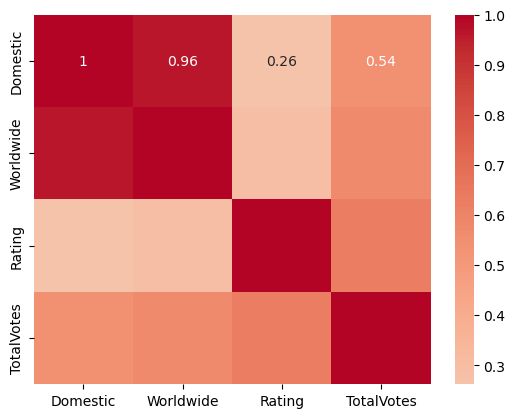

In [22]:
correlation_matrix = tables[['Domestic', 'Worldwide', 'Rating', 'TotalVotes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

## Domestic and Worldwide earnings have a very high correlation (0.96), indicating that movies with high domestic earnings tend to have high worldwide earnings.

## TotalVotes is moderately correlated with Domestic (0.54) and Worldwide earnings, suggesting that movies with higher earnings receive more votes.
## Rating shows a weak correlation with other variables, indicating that a movie's rating is less associated with its financial success.

# N 5

# Analyzing the relationship between genre and worldwide earnings

In [26]:
query7 = """
SELECT genre.genre, AVG(earning.Worldwide) AS Avg_Worldwide_Earnings
FROM earning 
JOIN genre ON earning.Movie_id = genre.Movie_id
GROUP BY genre.genre
ORDER BY Avg_Worldwide_Earnings DESC
LIMIT 10;
"""

top_earning_genres = conn.execute(query7).fetchall()
pd.read_sql(query7, conn)

genre  Avg_Worldwide_Earnings
0    Fantasy            8.462736e+08
1     Sci-Fi            6.198585e+08
2  Adventure            6.192983e+08
3     Action            6.020453e+08
4  Animation            5.852865e+08
5    Musical            4.418098e+08
6     Family            4.053277e+08
7   Thriller            3.551313e+08
8    Western            3.388226e+08
9    Mystery            3.034497e+08

In [27]:
top_earning_genres = pd.DataFrame(top_earning_genres)

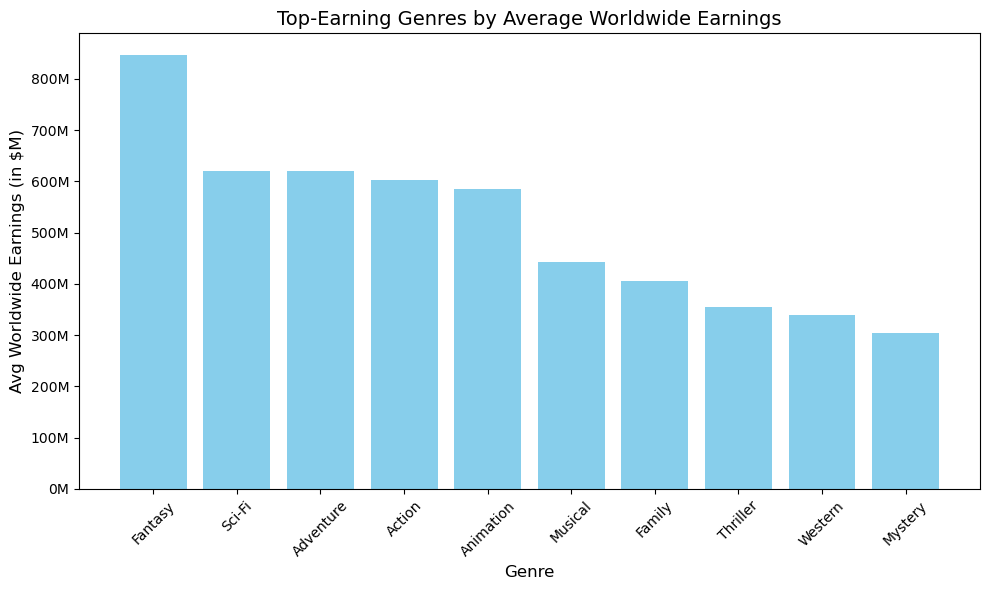

In [28]:
top_earning_genres.columns = ["Genre", "Avg_Worldwide_Earnings"]

plt.figure(figsize=(10, 6))
plt.bar(top_earning_genres["Genre"], top_earning_genres["Avg_Worldwide_Earnings"], color="skyblue")
plt.title("Top-Earning Genres by Average Worldwide Earnings", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Avg Worldwide Earnings (in $M)", fontsize=12)
plt.xticks(rotation=45)

formatter = ticker.FuncFormatter(lambda x, _: f'{int(x / 1e6)}M') # I did this for displaying the numbers in the y axis in millions
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

## The top-earning genres based on average worldwide earnings are: fantasy with an average worldwide earning of USD 846.3 million. Sci-Fi follows with USD 619.9 million. Adventure averages USD 619.3 million. Action averages USD 602.0 million and the animation: USD 585.3 million.

## This insight highlights the significant financial success of genres like Fantasy, Sci-Fi, and Adventure.

# N 6

# Analyzing the average rating for each genre based on IMDB data

In [32]:
query8 = """
SELECT genre.genre, AVG(IMDB.Rating) AS Avg_Rating, AVG(IMDB.TotalVotes) AS Avg_Votes
FROM IMDB
JOIN genre ON IMDB.Movie_id = genre.Movie_id
GROUP BY genre.genre
ORDER BY Avg_Rating DESC
LIMIT 10;
"""
top_rated_genres = conn.execute(query8).fetchall()
pd.read_sql(query8, conn)

genre  Avg_Rating      Avg_Votes
0      Music    8.233333  279560.333333
1    Western    8.000000  657246.000000
2     Sci-Fi    7.994444  626356.222222
3    History    7.950000  249790.166667
4    Mystery    7.914286  509332.285714
5  Animation    7.900000  307115.538462
6  Adventure    7.895349  451422.162791
7               7.890244  318691.365854
8     Action    7.875758  517590.060606
9      Crime    7.872727  389146.090909

In [33]:
top_rated_genres = pd.DataFrame(top_rated_genres)

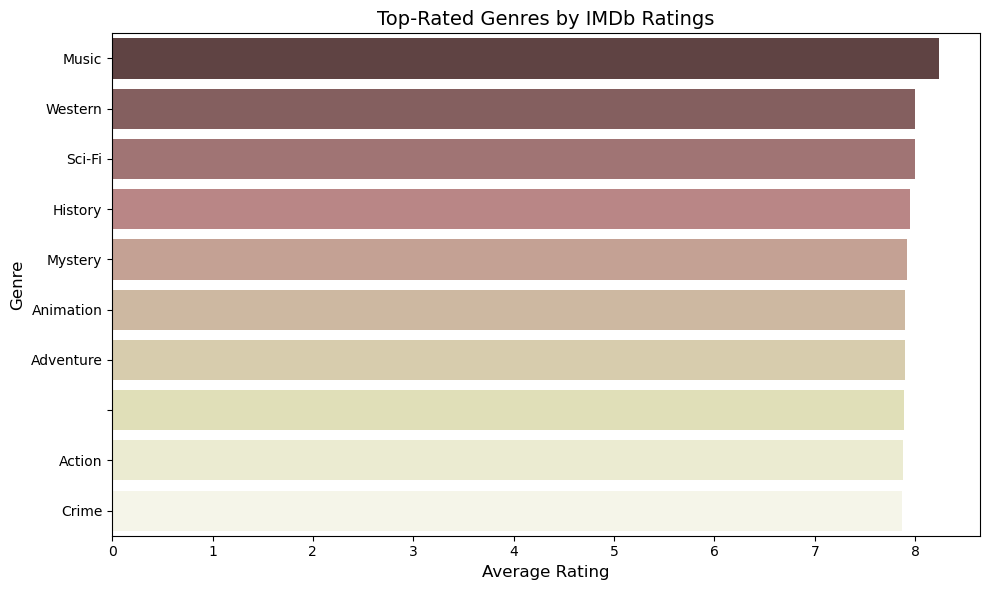

In [34]:
top_rated_genres.columns = ["Genre", "Avg_Rating", "Avg_Votes"]
plt.figure(figsize=(10, 6))
sns.barplot(x="Avg_Rating", y="Genre", data=top_rated_genres, palette="pink")
plt.title("Top-Rated Genres by IMDb Ratings", fontsize=14)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.tight_layout()
plt.show()

## Western follows with an average rating of 8.0 and 657,246 votes. Sci-Fi holds a strong position with an average rating of 7.99 and 626,356 votes. History is notable, with an average rating of 7.95 and 249,790 votes. And the mystery averages 7.91 with 509,332 votes.

## This shows that certain niche genres, such as Music and Western, tend to receive high ratings, even if they may not always be top earners. 

# N 7

# An interactive bar chart comparing male and female votes by genre.

In [38]:
query9 = """
SELECT genre.genre, 
       AVG(CAST(IMDB.CVotesMale AS INTEGER)) AS Avg_Male_Votes, 
       AVG(CAST(IMDB.CVotesFemale AS INTEGER)) AS Avg_Female_Votes
FROM IMDB
JOIN genre ON IMDB.Movie_id = genre.Movie_id
GROUP BY genre.genre
ORDER BY Avg_Male_Votes DESC
LIMIT 10;
"""

gender_votes_by_genre = conn.execute(query9).fetchall()
pd.read_sql(query9, conn)
gender_votes_by_genre = pd.DataFrame(gender_votes_by_genre)

gender_votes_by_genre.columns = ["Genre", "Avg_Male_Votes", "Avg_Female_Votes"]

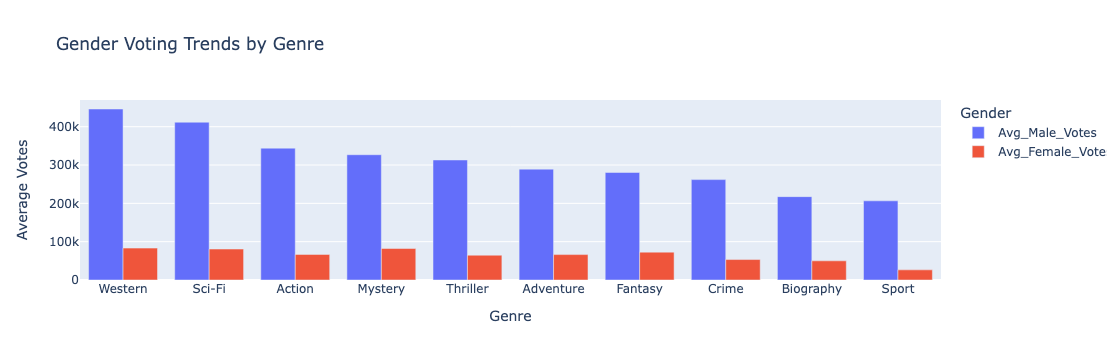

In [39]:
fig = px.bar(
    gender_votes_by_genre,
    x="Genre",
    y=["Avg_Male_Votes", "Avg_Female_Votes"],
    title="Gender Voting Trends by Genre",
    labels={"value": "Average Votes", "variable": "Gender"},
    barmode="group"
)
fig.show()

## Male audiences dominate voting trends across all genres, with the highest average votes for Western (around 446k) and Sci-Fi (around 411k).
## Female votes, while fewer in number, are higher for genres like Mystery and Sci-Fi, indicating relatively better gender engagement. 
## Thriller and Action genres have the lowest female voter participation among the shown genres. 
## These insights are crucial for marketing strategies to balance audience engagement.

# N 8

# Top 10 movies with the highest total earnings (sum of domestic and worldwide earnings).

In [43]:
query10 = """
SELECT
IMDB.Title AS Movie,
IMDB.Budget AS Budget_spent,
(earning.Domestic + earning.Worldwide) AS Total_Earning
FROM IMDB
JOIN earning ON IMDB.Movie_id = earning.Movie_id
WHERE IMDB.Budget IS NOT NULL
ORDER BY Total_Earning DESC
LIMIT 10;
"""
df_top_earnings = conn.execute(query10).fetchall()
pd.read_sql(query10, conn)

Movie  Budget_spent  Total_Earning
0       Star Wars: The Force Awakens (2015)   245000000.0   3.004886e+09
1                       The Avengers (2012)   220000000.0   2.142171e+09
2                          Rogue One (2016)   200000000.0   1.588235e+09
3         Captain America: Civil War (2016)   250000000.0   1.561389e+09
4              The Dark Knight Rises (2012)   250000000.0   1.533078e+09
5                        Toy Story 3 (2010)   200000000.0   1.481975e+09
6                            Skyfall (2012)   200000000.0   1.412921e+09
7                           Zootopia (2016)   150000000.0   1.365052e+09
8  The Hobbit: An Unexpected Journey (2012)   180000000.0   1.324107e+09
9    The Hunger Games: Catching Fire (2013)   130000000.0   1.289680e+09

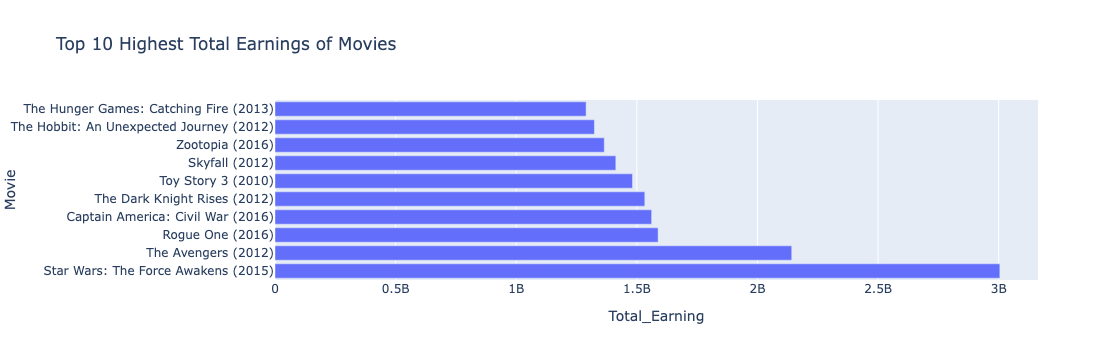

In [44]:
df_top_earnings = pd.read_sql(query10, conn)

fig = px.bar(df_top_earnings, x="Total_Earning", y="Movie", orientation="h",  title="Top 10 Highest Total Earnings of Movies")
fig.show()

## "Star Wars: The Force Awakens (2015)" has the highest total earnings, significantly outperforming the other movies, followed by "The Avengers (2012)" and "Rogue One (2016)".
## The dominance of blockbuster franchises (e.g., Star Wars, Marvel, and The Dark Knight) highlights the strong commercial appeal of sequels, well-established brands, and high-budget productions in generating massive earnings globally.

# N 9

# Number of movies per genre with ratings higher than 8.5.

In [48]:
query11 = """
SELECT genre.genre AS Genre,
COUNT(IMDB.Movie_id) AS High_Rating_Movie_Count
FROM genre
JOIN IMDB ON genre.Movie_id = IMDB.Movie_id
WHERE IMDB.Rating > 8.5
GROUP BY genre.genre
ORDER BY High_Rating_Movie_Count DESC;
"""

df_high_rating_movies = conn.execute(query11).fetchall()
pd.read_sql(query11, conn)

Genre  High_Rating_Movie_Count
0     Sci-Fi                        2
1  Adventure                        2
2      Drama                        1
3     Action                        1

In [49]:
# Converting df_high_rating_movies to a DataFrame
df_high_rating_movies = pd.DataFrame(
    df_high_rating_movies,
    columns=["Genre", "High_Rating_Movie_Count"]
)

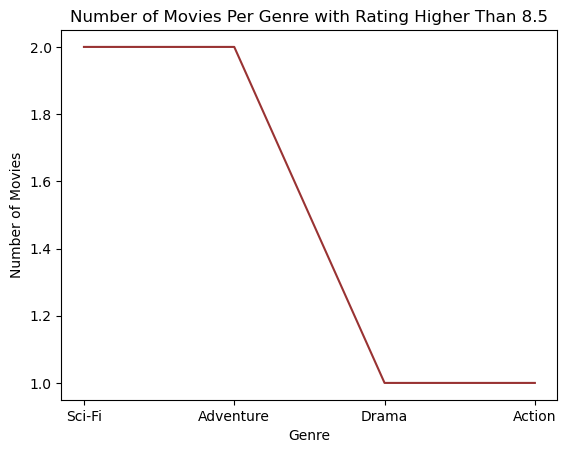

In [50]:
plt.plot( df_high_rating_movies["Genre"],  df_high_rating_movies["High_Rating_Movie_Count"],  color="maroon", alpha=0.8)
plt.title("Number of Movies Per Genre with Rating Higher Than 8.5")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

## Sci-Fi and Adventure genres have the most movies (2 each) with ratings above 8.5, followed by Drama and Action, which have just 1 movie each.
## This indicates that while high ratings (above 8.5) are relatively rare, genres like Sci-Fi and Adventure are more likely to produce exceptionally well-rated movies, possibly due to their appeal to audiences and strong storytelling elements.

# N 10

# Distributions of Rating, TotalVotes, and MetaCritic scores for movies in the dataset.

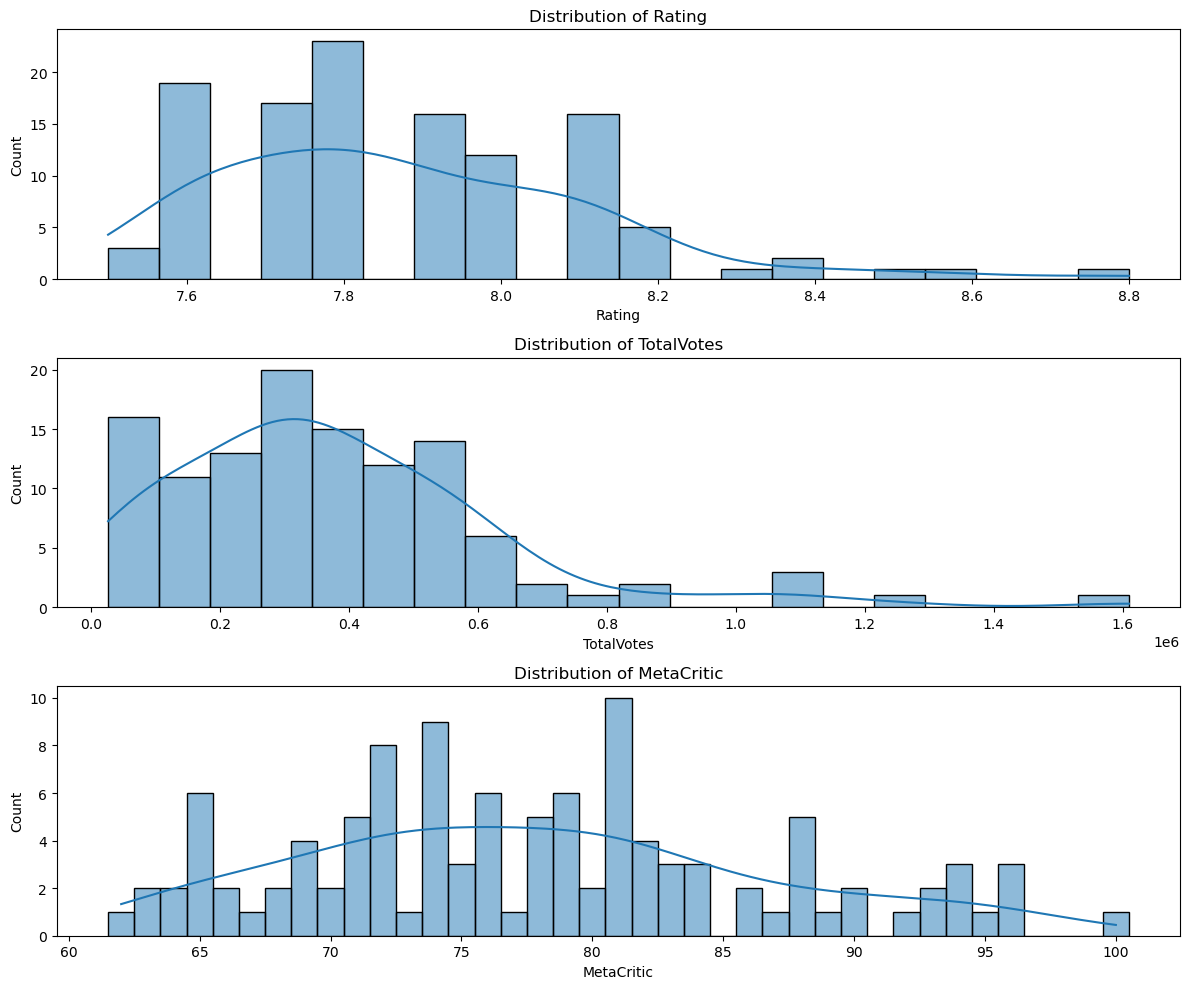

In [54]:
query11 = "SELECT Rating, TotalVotes, MetaCritic FROM IMDB"
IMDB = pd.read_sql(query11, conn)

numerical_cols = ["Rating", "TotalVotes", "MetaCritic"]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    sns.histplot(IMDB[col], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

## Rating: The distribution is tightly clustered between 7.5 and 8.5, indicating that most movies have moderate to high ratings, with very few movies achieving exceptionally high scores.
## TotalVotes: The distribution is right-skewed, showing that while most movies receive fewer votes, a small number of movies accumulate a significantly higher vote count.
## MetaCritic: The scores are spread across a broader range, but the concentration lies between 70 and 80, indicating that most movies receive average to above-average critical reviews.

# N 11

# Line chart displaying genres with Metacritic scores below 75, showing the average Metacritic scores for each genre.

In [58]:
query12 = """
SELECT genre.genre AS Genre,
IMDB.MetaCritic AS MetaCritic
FROM IMDB
JOIN genre ON IMDB.Movie_id = genre.Movie_id
WHERE IMDB.MetaCritic < 75
GROUP BY genre.genre;
"""

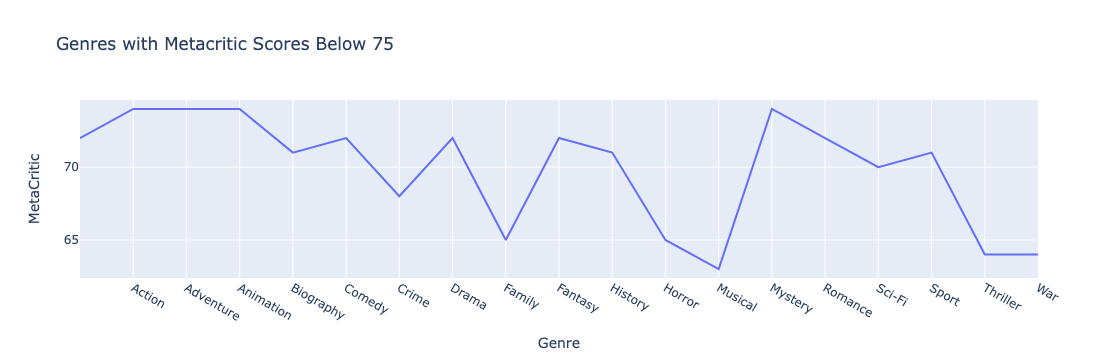

In [59]:
df_metacritic = pd.read_sql(query12, conn)

fig = px.line(df_metacritic,x="Genre", y="MetaCritic",title="Genres with Metacritic Scores Below 75"
)

fig.show()

## Horror and Thriller genres have the lowest Metacritic scores, indicating these genres are often rated poorly by critics.
## Genres like Animation, Mystery, and Adventure are closer to the upper threshold (near 75), suggesting more consistent performance but still falling short of exceptional critical acclaim.

# N 12

# A scatter plot visualizing the relationship between ratings and financial earnings.

In [63]:
query13 = """
SELECT genre.genre, 
       AVG(IMDB.Rating) AS Avg_Rating, 
       AVG(earning.Domestic) AS Avg_Domestic_Earnings,
       AVG(earning.Worldwide) AS Avg_Worldwide_Earnings
FROM IMDB
JOIN genre ON IMDB.Movie_id = genre.Movie_id
JOIN earning ON IMDB.Movie_id = earning.Movie_id
GROUP BY genre.genre
ORDER BY Avg_Worldwide_Earnings DESC
LIMIT 10;
"""

genre_rating_financial = conn.execute(query13).fetchall()
pd.read_sql(query13, conn)

genre  Avg_Rating  Avg_Domestic_Earnings  Avg_Worldwide_Earnings
0    Fantasy    7.814286           2.998283e+08            8.462736e+08
1     Sci-Fi    7.994444           2.406086e+08            6.198585e+08
2  Adventure    7.895349           2.340230e+08            6.192983e+08
3     Action    7.875758           2.429612e+08            6.020453e+08
4  Animation    7.900000           2.251912e+08            5.852865e+08
5    Musical    7.600000           1.488098e+08            4.418098e+08
6     Family    7.666667           1.392903e+08            4.053277e+08
7   Thriller    7.864286           1.364110e+08            3.551313e+08
8    Western    8.000000           1.670242e+08            3.388226e+08
9    Mystery    7.914286           1.442793e+08            3.034497e+08

In [64]:
genre_rating_financial = pd.read_sql(query13, conn)
genre_rating_financial.columns = ["Genre", "Avg_Rating", "Avg_Domestic_Earnings", "Avg_Worldwide_Earnings"]

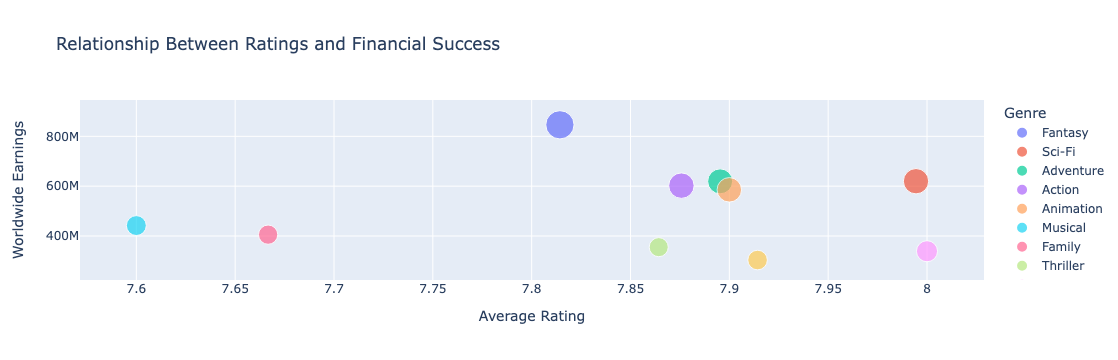

In [65]:
fig = px.scatter(
    genre_rating_financial,
    x="Avg_Rating",
    y="Avg_Worldwide_Earnings",
    size="Avg_Domestic_Earnings",
    color="Genre",
    title="Relationship Between Ratings and Financial Success",
    labels={"Avg_Rating": "Average Rating", "Avg_Worldwide_Earnings": "Worldwide Earnings"},
    hover_data=["Genre"]
)
fig.show()

## An interactive scatter plot showing the relationship between IMDb ratings and worldwide earnings, with the bubble size representing domestic earnings.

## Genres like Fantasy, Sci-Fi, and Adventure combine both high average earnings and reasonably high ratings.
## Animation, while highly rated, shows a slightly lower earnings range compared to other top genres.
## Action maintains consistent earnings but falls slightly behind in ratings compared to Fantasy and Sci-Fi.
## This visualization confirms that the most financially successful genres tend to maintain balanced appeal between audience ratings and financial performance.

# N 13

# The relationship between Average Earnings (in billions) and Average Rating

In [69]:
query14 = """
SELECT
    g.genre,
    AVG(e.Worldwide) AS avg_earnings,
    AVG(i.Rating) AS avg_rating,
    (AVG(e.Worldwide) * 0.7 + AVG(i.Rating) * 10 * 0.3) AS combined_score
FROM genre g
JOIN IMDB i ON g.Movie_id = i.Movie_id
JOIN earning e ON g.Movie_id = e.Movie_id
WHERE e.Worldwide IS NOT NULL AND i.Rating IS NOT NULL
GROUP BY g.genre
ORDER BY combined_score DESC
LIMIT 10;
"""
output = conn.execute(query14).fetchall()
pd.read_sql(query14, conn)

genre  avg_earnings  avg_rating  combined_score
0    Fantasy  8.462736e+08    7.814286    5.923916e+08
1     Sci-Fi  6.198585e+08    7.994444    4.339010e+08
2  Adventure  6.192983e+08    7.895349    4.335089e+08
3     Action  6.020453e+08    7.875758    4.214318e+08
4  Animation  5.852865e+08    7.900000    4.097006e+08
5    Musical  4.418098e+08    7.600000    3.092669e+08
6     Family  4.053277e+08    7.666667    2.837294e+08
7   Thriller  3.551313e+08    7.864286    2.485919e+08
8    Western  3.388226e+08    8.000000    2.371758e+08
9    Mystery  3.034497e+08    7.914286    2.124148e+08

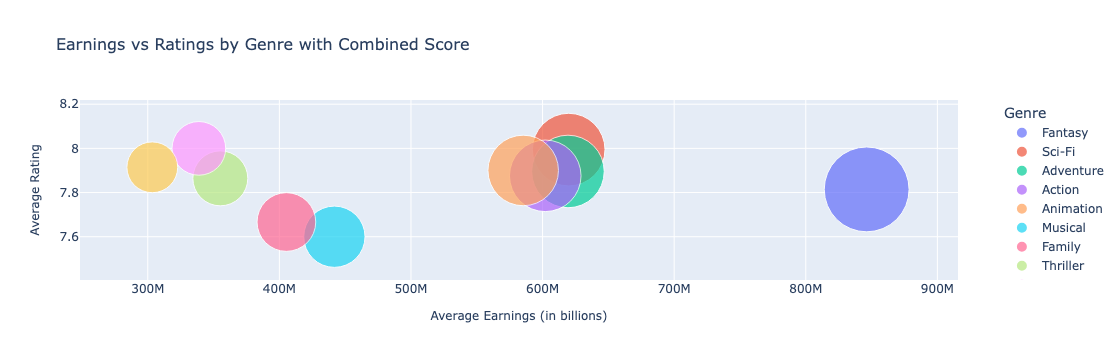

In [70]:
output = pd.DataFrame(output, columns=['genre', 'avg_earnings', 'avg_rating', 'combined_score'])

fig = px.scatter(
    output,
    x='avg_earnings',
    y='avg_rating',
    size='combined_score',
    color='genre',
    hover_name='genre',
    title='Earnings vs Ratings by Genre with Combined Score',
    labels={
        'avg_earnings': 'Average Earnings (in billions)',
        'avg_rating': 'Average Rating'
    },
    size_max=60,
    color_continuous_scale='Viridis'
)

fig.update_layout(
    legend=dict(
        title='Genre',
        x=1.05,
        y=1
    ),
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
)

fig.show()


## Each bubble represents a specific genre, where the size of the bubble is determined by a combined score, and the color differentiates genres.

## Genres with higher combined scores tend to cluster around higher average earnings and ratings, with some outliers having exceptional earnings or ratings.
## The largest bubble (likely corresponding to the "Fantasy" genre) signifies a genre with significantly higher combined scores, indicating its strong performance across both dimensions.

# N 14

# Total Domestic and World Earnings by Genre

In [74]:
query15="""
SELECT genre.genre, SUM(earning.Domestic) 
AS Total_Dom_Earnings 
FROM genre INNER JOIN earning 
ON genre.Movie_id = earning.Movie_id 
GROUP BY genre.genre 
ORDER BY Total_Dom_Earnings DESC LIMIT 10;
"""
top10_earning=pd.read_sql(query15, conn)

query16="""
SELECT genre.genre, 
SUM(earning.Worldwide) AS Total_World_Earnings 
FROM genre INNER JOIN earning 
ON genre.Movie_id = earning.Movie_id 
GROUP BY genre.genre 
ORDER BY Total_World_Earnings DESC LIMIT 10;
"""
top10_earning_world=pd.read_sql(query16, conn)
top10_earning_world

genre  Total_World_Earnings
0  Adventure          2.662983e+10
1     Action          1.986750e+10
2      Drama          1.301904e+10
3     Sci-Fi          1.115745e+10
4     Comedy          8.585548e+09
5                     8.221328e+09
6  Animation          7.608724e+09
7    Fantasy          5.923915e+09
8   Thriller          4.971838e+09
9  Biography          3.621331e+09

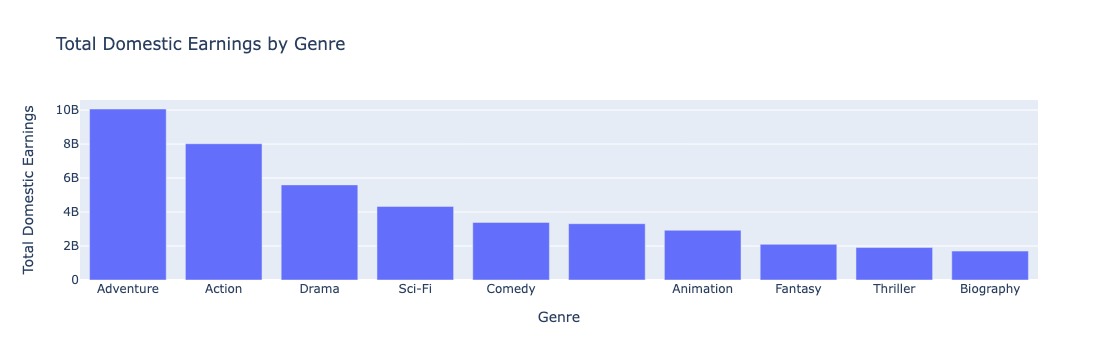

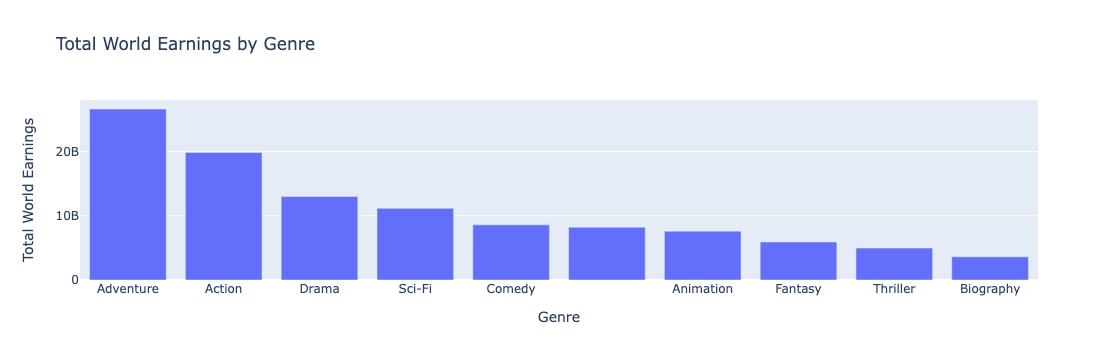

In [75]:
fig1 = px.bar(top10_earning, x="genre", y="Total_Dom_Earnings", 
              title="Total Domestic Earnings by Genre", 
              labels={"genre": "Genre", "Total_Dom_Earnings": "Total Domestic Earnings"})

fig2 = px.bar(top10_earning_world, x="genre", y="Total_World_Earnings", 
              title="Total World Earnings by Genre", 
              labels={"genre": "Genre", "Total_World_Earnings": "Total World Earnings"})

fig1.show()
fig2.show()

## The graphs compare total domestic and world earnings by genre. The Adventure genre leads in both categories, followed by Action and Drama. Genres like Thriller and Biography show significantly lower earnings in both domestic and global markets.

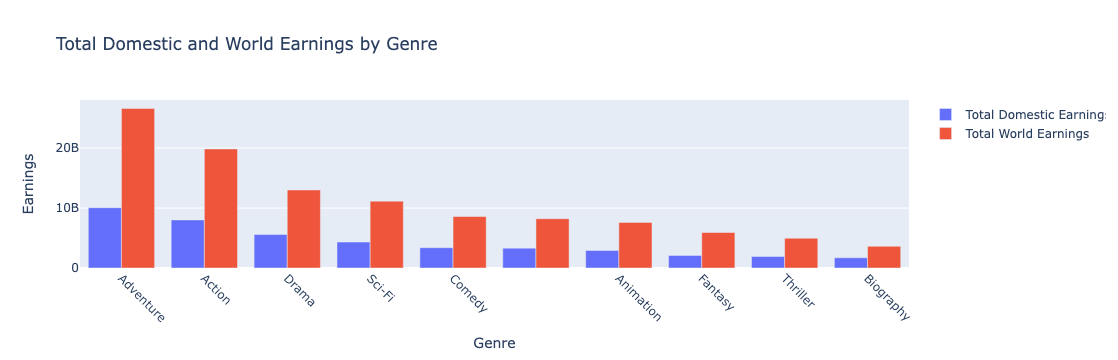

In [77]:
fig3 = go.Figure()
fig3.add_trace(go.Bar( x=fig1.data[0].x, y=fig1.data[0].y, name='Total Domestic Earnings'))
fig3.add_trace(go.Bar(x=fig2.data[0].x,y=fig2.data[0].y, name='Total World Earnings'))
fig3.update_layout(title="Total Domestic and World Earnings by Genre", xaxis=dict(title="Genre"), yaxis=dict(title="Earnings"), barmode='group', xaxis_tickangle=45)

fig3.show()

## The combined graph highlights the difference between domestic and world earnings, with Adventure and Action demonstrating substantial global dominance. This suggests a strong international appeal for these genres compared to others.

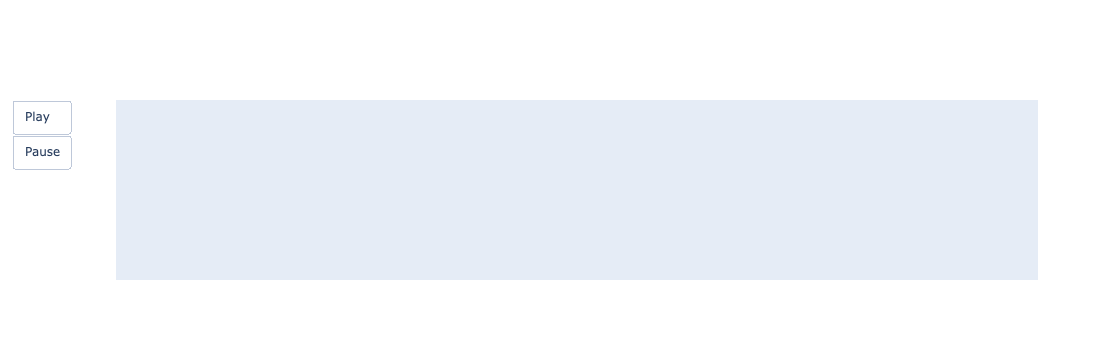

In [161]:
frames = ['T', 'Th', 'Tha', 'Than', 'Thank', 'Thank Y', 'Thank Yo', 'Thank You!']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[0.5], y=[0.5],  # Center position
    text=[""],  # Placeholder
    mode="text",
    textfont=dict(size=30, color="blue"),
))
fig.frames = [
    go.Frame(data=[
        go.Scatter(
            x=[0.5],
            y=[0.5],
            text=[frames[i]],
        )
    ]) for i in range(len(frames))
]

fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    showlegend=False,
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True)]
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[None, dict(frame=dict(duration=0, redraw=False))]
                )
            ]
        )
    ]
)

fig.show()